Imports e carregamento dos arquivos no google Drive.

In [1]:
import os

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report

import keras.utils
from shapely.geometry import Polygon
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


Descompactação dos panoramas. As imagens já estão divididas nas pastas indicando o label, no formato exigido pela função de carregamento do keras.

In [3]:
!unzip "/content/drive/MyDrive/TCC/panoramas_cat.zip" -d "/content"

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/panoramas_cat/2/-15.974753383594292,-48.07012173158858.png  
  inflating: /content/panoramas_cat/2/-15.975201968112707,-48.010493473564125.png  
  inflating: /content/panoramas_cat/2/-15.975341025476652,-48.08374018740349.png  
  inflating: /content/panoramas_cat/2/-15.975494956828996,-48.07061989988472.png  
  inflating: /content/panoramas_cat/2/-15.975756381762011,-48.03918236535565.png  
  inflating: /content/panoramas_cat/2/-15.976290030357452,-48.03949245918264.png  
  inflating: /content/panoramas_cat/2/-15.976429389505848,-47.987885575294506.png  
  inflating: /content/panoramas_cat/2/-15.976454359718648,-47.98868273257603.png  
  inflating: /content/panoramas_cat/2/-15.976559518220844,-47.991642821459905.png  
  inflating: /content/panoramas_cat/2/-15.97657484975334,-48.008321701614506.png  
  inflating: /content/panoramas_cat/2/-15.976998519518819,-48.00885777540235.png  
  inflating: /content/pan

Mostra as divisões no mapa, cada setor é numerado e usado como alvo para a classificação.

In [ ]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import folium

VERTICES = [
    (-16.0349249, -47.6078796),
    (-15.5803800, -47.6315689),
    (-15.5767422, -48.1039810),
    (-16.0507626, -48.2316971)
]

def subdivide_polygon(polygon, num_subdivisions):
    minx, miny, maxx, maxy = polygon.bounds
    dx = (maxx - minx) / num_subdivisions
    dy = (maxy - miny) / num_subdivisions

    subdivided_polygons = []
    for i in np.arange(minx, maxx, dx):
        for j in np.arange(miny, maxy, dy):
            square = Polygon([(i, j), (i+dx, j), (i+dx, j+dy), (i, j+dy)])
            if polygon.intersects(square):
                subdivided_polygons.append(polygon.intersection(square))

    return subdivided_polygons

polygon = Polygon(VERTICES)
gdf = gpd.GeoDataFrame(index=[0], geometry=[polygon])

approx_sqrt_sections = int(np.sqrt(25))
subdivided_polygons = subdivide_polygon(polygon, approx_sqrt_sections)

subdivided_polygons_with_id = [(i, poly) for i, poly in enumerate(subdivided_polygons, start=1)]
subdivided_gdf_with_id = gpd.GeoDataFrame(subdivided_polygons_with_id, columns=['ID', 'geometry'])

m = folium.Map(location=[polygon.centroid.x, polygon.centroid.y], zoom_start=10)

for idx, row in subdivided_gdf_with_id.iterrows():
    sub_poly = row['geometry']
    coords = sub_poly.exterior.coords.xy
    folium_polygon = folium.Polygon(locations=list(zip(coords[0], coords[1])), fill_color='grey', fill_opacity=0.4, color='blue')
    folium_polygon.add_to(m)
    label = str(row['ID'])
    folium.Marker(
        location=[sub_poly.centroid.x, sub_poly.centroid.y],
        icon=folium.DivIcon(html=f'<div style="font-size: 12pt; color: black; font-weight: bold">{label}</div>')
    ).add_to(m)
m


Exemplo da densidade de imagem por região, marcar todas causa lentidão.

In [ ]:
image_dir = '/content/panoramas_cat/4/'

m = folium.Map(location=[-15.8, -47.7], zoom_start=11)

images = os.listdir(os.path.join(image_dir))

for image in images:
    lat, lng = image.split(",")[:2]

    lat = float(lat)
    lng = float(lng[:-4])

    folium.Marker(location=[lat, lng], popup=image).add_to(m)

m

Carrega as imagens já divididas em grupos de treino e teste no formato exigido pela função nativa do keras. A função nativa é muito mais eficiente do que fazer a leitura das imagens manualmente.

In [ ]:
DIRECTORY = '/content/panoramas_cat/'
COLOR_MODE = 'rgb' #grayscale / rgb
IMG_SIZE = (400, 2560)

train_data, validation_data = keras.utils.image_dataset_from_directory(
    DIRECTORY,
    labels="inferred",
    label_mode="categorical",
    color_mode=COLOR_MODE,
    batch_size=32,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 11583 files belonging to 25 classes.
Using 9267 files for training.
Using 2316 files for validation.


Constrói o modelo a partir de um modelo pré treinado do ResNet50, adicionando mais algumas camadas.

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(400, 2560, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(25, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 13, 80, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                         

Treinamento do modelo, usando o ambiente mais rápido fornecido pelo colab pro, cada época leva ~135 segundos, mas pode variar dependendo da disponibilidade de recursos.

In [ ]:
history = model.fit(train_data, validation_data=validation_data, epochs=50)
model.save('/content/drive/MyDrive/TCC/cinquenta-final.h5')

Epoch 1/50
290/290 [==============================] - 159s 488ms/step - loss: 3.3030 - accuracy: 0.1837 - val_loss: 2.3104 - val_accuracy: 0.2984
Epoch 2/50
290/290 [==============================] - 135s 463ms/step - loss: 2.5902 - accuracy: 0.2611 - val_loss: 2.0945 - val_accuracy: 0.3636
Epoch 3/50
290/290 [==============================] - 135s 463ms/step - loss: 2.3180 - accuracy: 0.2933 - val_loss: 1.9799 - val_accuracy: 0.3709
Epoch 4/50
290/290 [==============================] - 135s 463ms/step - loss: 2.1768 - accuracy: 0.3247 - val_loss: 1.9166 - val_accuracy: 0.3890
Epoch 5/50
290/290 [==============================] - 135s 463ms/step - loss: 2.0750 - accuracy: 0.3571 - val_loss: 1.8720 - val_accuracy: 0.3985
Epoch 6/50
290/290 [==============================] - 135s 463ms/step - loss: 1.9896 - accuracy: 0.3696 - val_loss: 1.8444 - val_accuracy: 0.4072
Epoch 7/50
290/290 [==============================] - 135s 463ms/step - loss: 1.9421 - accuracy: 0.3841 - val_loss: 1.8144 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Gráficos de perda e acurácia do treino.

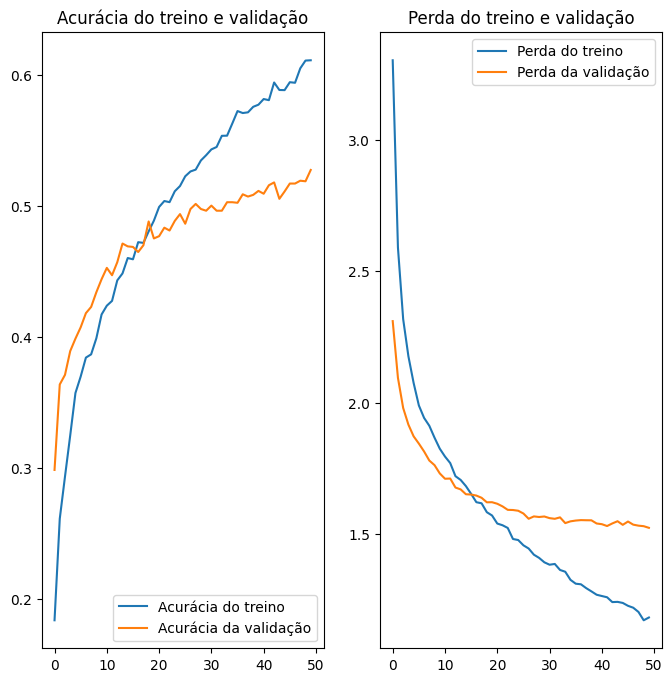

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Acurácia do treino')
plt.plot(val_acc, label='Acurácia da validação')
plt.legend(loc='lower right')
plt.title('Acurácia do treino e validação')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Perda do treino')
plt.plot(val_loss, label='Perda da validação')
plt.legend(loc='upper right')
plt.title('Perda do treino e validação')
plt.show()

Relatório de classificação e matriz de confusão.

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/TCC/cinq.h5')

In [ ]:
y_true = np.concatenate([y for x, y in validation_data], axis=0).argmax(axis=1)

y_pred = model.predict(validation_data).argmax(axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

class_report = classification_report(y_true, y_pred)

print(class_report)


73/73 [==============================] - 27s 363ms/step
              precision    recall  f1-score   support

           0       0.55      0.70      0.62        40
           1       0.71      0.71      0.71         7
           2       0.57      0.54      0.55       145
           3       0.52      0.56      0.54       284
           4       0.53      0.80      0.64       331
           5       0.46      0.35      0.39       130
           6       0.70      0.44      0.54        16
           7       0.38      0.63      0.47        19
           8       0.36      0.42      0.38        12
           9       0.53      0.24      0.33       135
          10       0.50      0.58      0.54       151
          11       0.60      0.40      0.48       190
          12       0.50      0.61      0.55        36
          13       0.43      0.60      0.50         5
          14       0.54      0.72      0.62        18
          15       0.65      0.63      0.64        27
          16       0.57  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matriz de confusão no Seaborn para facilitar visualização.

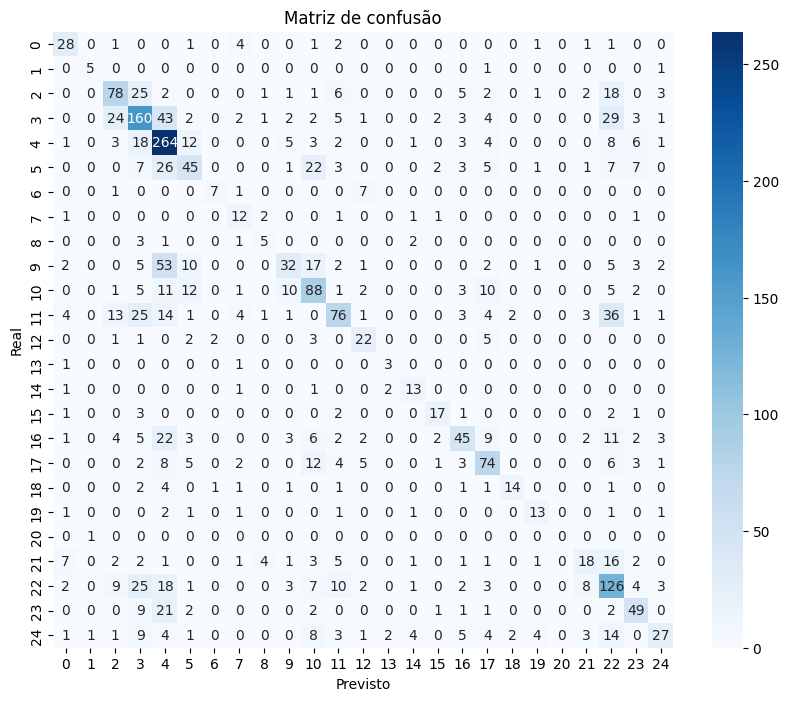

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Real')
plt.title('Matriz de confusão')
plt.xlabel('Previsto')
plt.show()

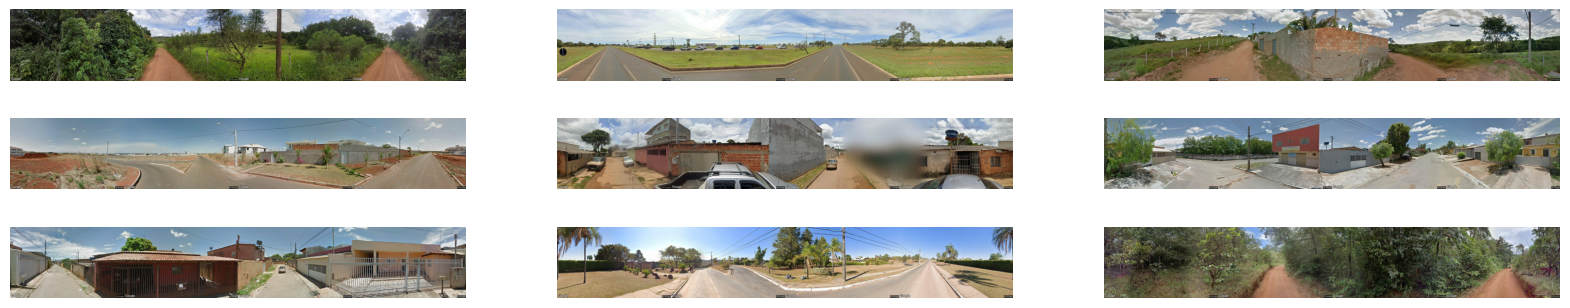

In [ ]:
image_dir = '/content/panoramas_cat/9/'

images = os.listdir(image_dir)

random_images = np.random.choice(images, size=9)

fig, axes = plt.subplots(3, 3, figsize=(20, 4))

for i, image in enumerate(random_images):
    img = load_img(os.path.join(image_dir, image), target_size=(400, 2560))

    img_array = img_to_array(img)

    img_array /= 255.0

    ax = axes[i // 3, i % 3]

    ax.imshow(img_array)
    ax.axis('off')

plt.show()

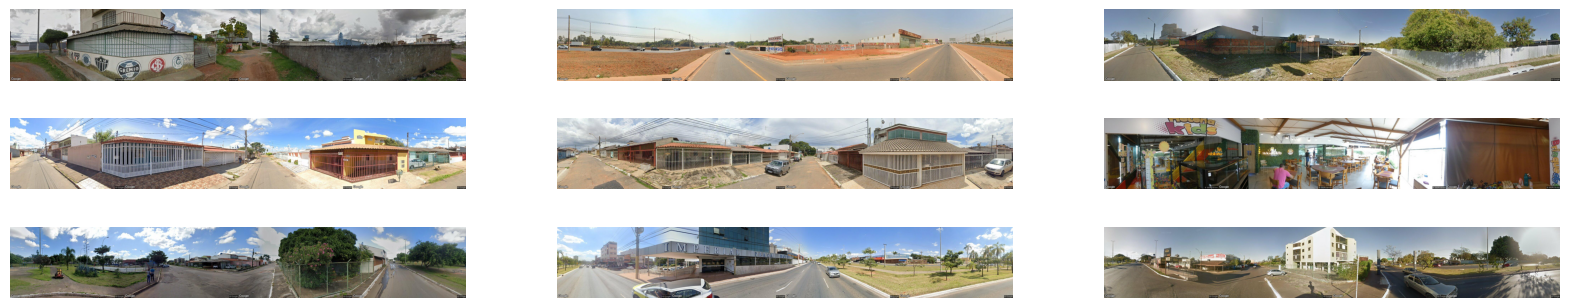

In [10]:
image_dir = '/content/panoramas_cat/12/'

images = os.listdir(image_dir)

random_images = np.random.choice(images, size=9)

fig, axes = plt.subplots(3, 3, figsize=(20, 4))

for i, image in enumerate(random_images):
    img = load_img(os.path.join(image_dir, image), target_size=(400, 2560))

    img_array = img_to_array(img)

    img_array /= 255.0

    ax = axes[i // 3, i % 3]

    ax.imshow(img_array)
    ax.axis('off')

plt.show()